In [1]:
import pandas as pd
import numpy as np

In [12]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [2]:
df = pd.read_pickle('data/ndf_txt_vec1.pkl')

> **doc2vec**
* tokenize + doc2vec + 가계부실선행지수

In [5]:
df.columns

Index(['qry', 'title', 'text', 'tok_tit', 'tok_txt', 'tag_tit', 'tag_txt',
       'dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
       'cycle', 'tcycle', '가계소득지표', '가계소비지표', '차입수준지표'],
      dtype='object')

In [6]:
df['tag1'] = np.where(df.tcycle>100,1,0)
df['tag2'] = np.where(df.cycle>100,1,0)

In [7]:
df.tag1.value_counts(dropna=False)

0    195
1     12
Name: tag1, dtype: int64

In [8]:
df.tag2.value_counts(dropna=False)

0    168
1     39
Name: tag2, dtype: int64

### _**토크나이즈(tokenize)**_  
가계부실선행지수 순환변동치의 100초과 여부를 tag로 하여 리모델링 

In [16]:
tagdoc = lambda txt, tag: [TaggedDocument(words=txt,tags=[tag])]

In [17]:
df['tag_txt'] = df.apply(lambda x: tagdoc(x.tok_txt,x.tag2),axis=1)

### _**모델링(doc2vec)**_

In [23]:
import multiprocessing
cores = multiprocessing.cpu_count()
from sklearn import utils
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [24]:
%%time
# text(기사본문) 벡터화
tag_txt = [t for x in df.tag_txt for t in x]
# 토큰업로드
max_epochs = 30
vec_size = 10
alpha = 0.025

model_dbow_txt = Doc2Vec(dm=0,
                     vector_size=vec_size,
                     alpha=alpha, 
                     min_alpha=0.00025,
                     min_count=1,
                     workers=cores)
model_dbow_txt.build_vocab(tag_txt)
# 모델피팅
for epoch in range(30):
    model_dbow_txt.train(utils.shuffle([x for tt in tqdm(df.tag_txt) for x in tt]),
                    total_examples=model_dbow_txt.corpus_count,
                    epochs=10)
    model_dbow_txt.alpha -= 0.002
    model_dbow_txt.min_alpha = model_dbow_txt.alpha

In [26]:
# 벡터라이징
dvec1 = list(map(lambda x: model_dbow_txt.infer_vector(x), df.tok_txt))
cname = ['dx'+str(i) for i in np.arange(1,vec_size+1)]
dvec1 = pd.DataFrame(dvec1,columns = cname)
# Wall time: 1min 25s

In [31]:
df1 = df.reset_index()
df1 = df1[['ym','cycle','tag2','tok_txt','tag_txt']]

In [32]:
df_txt_vec = pd.concat([df1,dvec1],axis=1)

In [33]:
df_txt_vec.head()

,ym,cycle,tag2,tok_txt,tag_txt,dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10
0,200201,NaN,0,"[신용카드/Noun, 부실/Noun, 도화선/Noun, 서울/Noun, 연합뉴스/N...","[([신용카드/Noun, 부실/Noun, 도화선/Noun, 서울/Noun, 연합뉴스...",-1.549966,-1.808303,-2.174805,-2.613304,2.077370,0.188326,4.280576,-2.687513,1.670563,-2.915860
1,200202,NaN,0,"[지난해/Noun, 말/Noun, 현재/Noun, 가계부채/Noun, 사상/Noun...","[([지난해/Noun, 말/Noun, 현재/Noun, 가계부채/Noun, 사상/No...",-1.330204,-1.744064,-1.861258,-2.584375,2.196874,0.022426,4.310096,-2.747510,1.808292,-2.829481
2,200203,NaN,0,"[송인/Noun, 호/Noun, 기자/Noun, 최근/Noun, 가계부채/Noun,...","[([송인/Noun, 호/Noun, 기자/Noun, 최근/Noun, 가계부채/Nou...",-1.635818,-1.802207,-1.894568,-2.636186,2.096484,0.110383,4.311095,-2.748131,1.790520,-2.923226
3,200204,NaN,0,"[가계/Noun, 부문/Noun, 금융/Noun, 부채/Noun, 국내총생산/Nou...","[([가계/Noun, 부문/Noun, 금융/Noun, 부채/Noun, 국내총생산/N...",-1.517601,-1.784186,-1.879360,-2.850881,2.168005,-0.031327,4.308851,-2.707417,1.652408,-2.861773
4,200205,NaN,0,"[미경/Noun, 제/Noun, 둔화/Noun, 환율/Noun, 하락/Noun, 등...","[([미경/Noun, 제/Noun, 둔화/Noun, 환율/Noun, 하락/Noun,...",-1.395456,-1.796114,-2.075791,-2.672758,2.111469,0.294718,4.443990,-2.711839,1.591720,-2.637690


In [37]:
df_txt_vec['date'] = pd.to_datetime(df_txt_vec.ym, format='%Y%m')

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
plt.rcParams['font.family'] = 'NanumGothic'

In [41]:
plt.rcParams['axes.unicode_minus'] = False

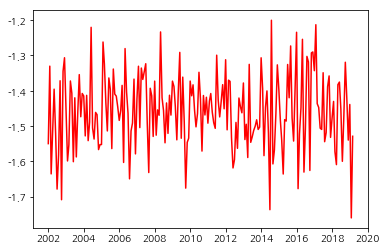

In [42]:
plt.plot_date(df_txt_vec.date,df_txt_vec.dx1,'-r')

Text(0.5, 1.0, 'dx3')

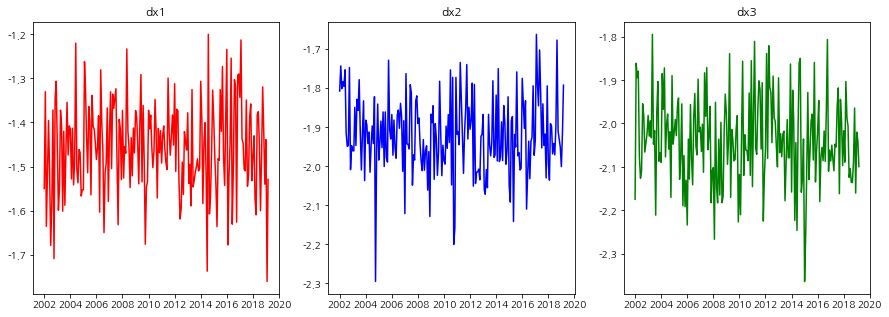

In [57]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot_date('date','dx1','-r',data=df_txt_vec)
ax[0].set_title('dx1')
ax[1].plot_date('date','dx2','-b',data=df_txt_vec)
ax[1].set_title('dx2')
ax[2].plot_date('date','dx3','-g',data=df_txt_vec)
ax[2].set_title('dx3')

In [50]:
'dx'+str(i+1)

'dx1'

In [54]:
list(range(5))

[0, 1, 2, 3, 4]

In [72]:
import matplotlib as mpl

In [109]:
import matplotlib.dates as mdates

In [115]:
years = mdates.YearLocator(base=3)
yrfmt = mdates.DateFormatter("'%y")

In [116]:
plt.rcParams['font.size']=12

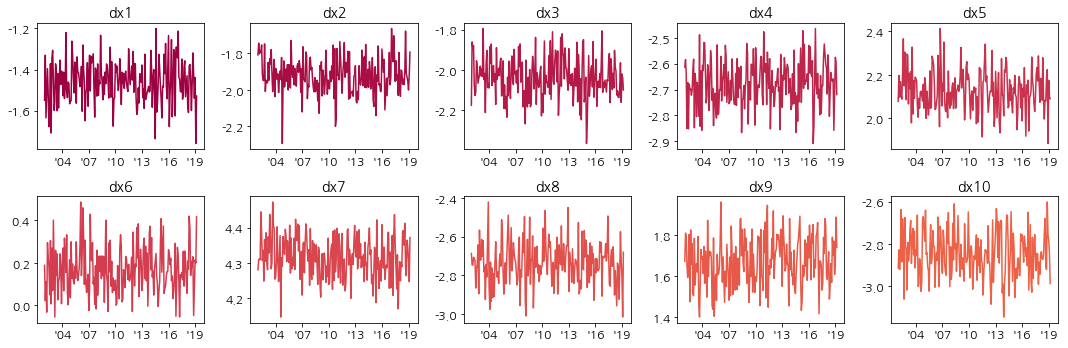

In [118]:
fig, ax = plt.subplots(2,5,figsize=(15,5))
n = 0
cols = plt.get_cmap('Spectral')
for i in range(2):
    for j in range(5):
        y = 'dx'+str(n+1)
        ax[i,j].plot_date('date',y,'-',data=df_txt_vec,label=y,color=cols(n*5))
        ax[i,j].set_title(y)
        ax[i,j].xaxis.set_major_locator(years)
        ax[i,j].xaxis.set_major_formatter(yrfmt)
        n +=1
        plt.tight_layout()
# fig.autofmt_xdate()        

In [105]:
pwd

'Z:\\proj\\pub_info'

In [119]:
df_txt_vec.columns

Index(['ym', 'cycle', 'tag2', 'tok_txt', 'tag_txt', 'dx1', 'dx2', 'dx3', 'dx4',
       'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10', 'date'],
      dtype='object')

In [120]:
df_txt_vec.to_pickle('data/ndf_bstag.pkl')
df_txt_vec.drop('tag_txt',axis=1).to_pickle('o:/보낼파일함/ndf_bstag.pkl')